In [1]:
%matplotlib inline
import skimage.io as io
import numpy as np
import bqplot as bq
from threading import Thread, Lock
import time
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cell_img = io.imread("./data/cell_3ch_patch.tif").astype(float)
cell_mask = io.imread("./data/mask.tif").astype(bool)

In [3]:
def line_array(color,i):
    import numpy as np
    if (color=="cyan") or (color=="c"):
        line = np.array([0/256, (i+1)/256, (i+1)/256, 1])
    elif (color=="magenta") or (color=="m"):
        line = np.array([(i+1)/256, 0/256, (i+1)/256, 1])
    elif (color=="lightblue") or (color=="lb"):
        line = np.array([(i+1)/380, (i+1)/304, (i+1)/286, 1])
    elif (color=="pink") or (color=="p"):
        line = np.array([(i+1)/256, (i+1)/361, (i+1)/341, 1])
    return(line)
def create_fluo_cm(color):
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    import numpy as np
    grays = cm.get_cmap('gray', 256)
    newcolors = grays(np.linspace(0, 1, 256))
    for i in range(1,newcolors.shape[0]):
        newcolors[i,:] = line_array(color,i)
    newcmp = ListedColormap(newcolors)
    return(newcmp)

In [4]:
cyan_cm = create_fluo_cm("c")
magenta_cm = create_fluo_cm("m")
pink_cm = create_fluo_cm("p")
lightblue_cm = create_fluo_cm("lb")
cm_list = [magenta_cm, cyan_cm, pink_cm, lightblue_cm]

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_21016\1358212915.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  grays = cm.get_cmap('gray', 256)


In [5]:
class IonChannel(object):
    def __init__(self,ion,lin,col,ide):
        self.id = ide
        self.x = int(col)
        self.y = int(lin)
        self.ion = ion
        self.state = 'closed'
    def ch_open(self):
        self.state = 'open'
    def ch_close(self):
        self.state = 'closed'

In [6]:
def create_channels(n=20,ion='K+'): 
    import skimage.measure as measure
    global cell_mask
    import numpy as np
    # get cell contour
    contours = measure.find_contours(cell_mask.astype(int),0)
    # calculate the step size necessary to divide the contours vector in 30 pieces
    step = len(contours[0])//20
    # calculate the rest that is left of the vector after dividing it in 30 pieces
    rest = len(contours[0])%20
    
    if ion=='K+':
        # takes the coordinates of each step
        coords = contours[0][::step]
        coords = coords[:-1]
    else:
        # takes the coordinates of each step, but starting at half step
        coords = contours[0][step//2::step] 
    
    ch_list = []
    coords = coords[np.random.choice(20, n, replace=False)]
    for counter,value in enumerate(coords):
        ch_list.append(IonChannel(ion,value[0],value[1],counter))
    return(ch_list)

In [7]:
'''################ Reference parameters: concentrations, conductances, potentials and currents ################'''
conc_Na_i_ref = 15   # [Na]i reference (mM)
conc_K_i_ref = 140   # [K]i reference  (mM)
conc_Na_o_ref = 150  # [Na]o reference (mM)
conc_K_o_ref = 5     # [K]o reference  (mM)

G_K_ref = 2500  # K conductance reference (pS)
G_Na_ref = 445  # Na conductance reference (pS)

E_K_ref = -0.06*np.log10(conc_K_i_ref / conc_K_o_ref)  # K equilibrium potential (V)
E_Na_ref = -0.06*np.log10(conc_Na_i_ref / conc_Na_o_ref) # Na equilibrium potential (V)

Vm_init = ( (E_K_ref)*G_K_ref + (E_Na_ref)*G_Na_ref ) \
           / (G_K_ref + G_Na_ref)   # membrane equilibrium potential (V)

I_K_ref = (Vm_init - E_K_ref) * G_K_ref*1e-12 # K current reference (A)
I_Na_ref = (Vm_init - E_Na_ref) * G_Na_ref*1e-12 # Na current reference (A)

'''################ Reference parameters: cell parameters ################'''

cell_radius = 5 # cell radius (um)
cell_vol = (4/3)*np.pi*((cell_radius*1e-6)**3)*1000 # cell volume (L) *slightly different from excel
cell_capacitance = 4*np.pi*(cell_radius**2)*0.01  # cell capacitance (pF)
Rm_ref = 1000/(G_K_ref+G_Na_ref)  # membrane resistance (GOhm)
tau_ref = Rm_ref*cell_capacitance*1e-3  # time constant (s)

'''################ Reference parameters: permeabilities and fluxes ################'''

R = 8.314  # universal gas constant (J*K-1*mol-1)
T = 310.15 # temperature (K)
F = 96485  # Farady cinstant (C*mol-1)
z = 1      # charge number (+1 for K+ and Na+)

alpha = z*F*Vm_init/(R*T)
# K permeability (C*s-1*V-1)
P_K_ref = ( G_K_ref*1e-12*R*T * ( 1 - np.exp(alpha) )*(Vm_init - E_K_ref) ) \
            / ( (z**2)*(F**2)*Vm_init \
              * (conc_K_o_ref - conc_K_i_ref*(np.exp(alpha)) ) )
# Na permeability (C*s-1*V-1)
P_Na_ref = ( G_Na_ref*1e-12*R*T * ( 1 - np.exp(alpha) )*(Vm_init - E_Na_ref) ) \
            / ( (z**2)*(F**2)*Vm_init \
              * (conc_Na_o_ref - conc_Na_i_ref*(np.exp(alpha)) ) )

J_K_ref = I_K_ref/F    # K flow (mol/s)
J_Na_ref = I_Na_ref/F  # Na flow (mol/s)

'''################ Reference parameter: membrane equilibrium potential ################'''
# membrane equilibrium potential (V) by GHK
Vm_ref = 0.06*np.log10(((P_K_ref*conc_K_o_ref) + (P_Na_ref*conc_Na_o_ref)) \
                         / ((P_K_ref*conc_K_i_ref) + (P_Na_ref*conc_Na_i_ref))) 
Vm = Vm_ref
potential = Vm_ref*1000
# print('potential = ',potential)
Vm_old = Vm_ref*1000

time_step = 0.01

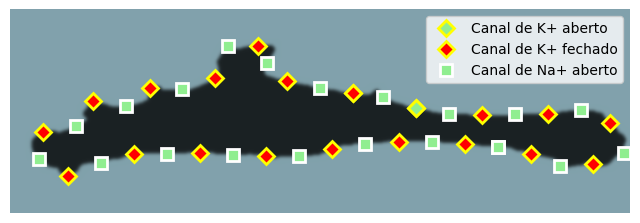

In [ ]:
'''################ Callback functions ################'''
def on_power(v):
    global power_status, th, first_power_on_flag
    if power_status==True:
        power_button.button_style = 'danger'
        enable_controls(False)
        power_status = False
    else:
        # starts simulator for the first time (and start thread)
        if first_power_on_flag==False:
            # start thread
            th.start()
            first_power_on_flag = True
        else:
            channel_sel.disabled = False
            adv_check.disabled = False
            reset()
        power_button.button_style = 'success'
        enable_controls(True)
        
        power_status = True

def enable_controls(flag):
    if flag==True:
        channel_sel.disabled = False
        K_i_slider.disabled = False
        K_o_slider.disabled = False
        Na_i_slider.disabled = False
        Na_o_slider.disabled = False
        K_ch_slider.disabled = False
        Na_ch_slider.disabled = False
        adv_check.disabled = False
        refresh_button.disabled = False
        clear_button.disabled = False
    else:
        channel_sel.disabled = True
        K_i_slider.disabled = True
        K_o_slider.disabled = True
        Na_i_slider.disabled = True
        Na_o_slider.disabled = True
        K_ch_slider.disabled = True
        Na_ch_slider.disabled = True
        adv_check.disabled = True
        refresh_button.disabled = True
        clear_button.disabled = True
    return
        
def on_show_Fick(v):
    global show_Fick
    show_Fick = v['new']
    
    # Update the figure marks based on show_Fick state
    if show_Fick == True:
        # Add Fick lines to the plot
        fig2.marks = [line_K_i, line_K_o, line_Na_i, line_Na_o, line_K_i_Fick, line_Na_i_Fick]
        # Show Fick labels
        label_delta_K_i_Fick.layout.visibility = 'visible'
        label_delta_Na_i_Fick.layout.visibility = 'visible'
    else:
        # Remove Fick lines from the plot
        fig2.marks = [line_K_i, line_K_o, line_Na_i, line_Na_o]
        # Hide Fick labels
        label_delta_K_i_Fick.layout.visibility = 'hidden'
        label_delta_Na_i_Fick.layout.visibility = 'hidden'
    
    # Update the screen to reflect colormap changes if needed
    update_screen(channel_sel.index)
    
def on_refresh_button(v):
    global refresh_flag
    refresh_flag = True
    reset()
    refresh_flag = False
    
def on_clear(v):
    global clear_flag
    clear_flag = True
#     reset()
#     clear_flag = False

def on_channel_sel(v):
    value = v['owner'].index
    update_screen(value)

# Updates image from channel selection change
def update_screen(ch_index):
    '''Function that updates images when images need to be update 
    (for example, when channel is changed)'''
    from skimage.filters import gaussian
    from numpy import invert
    global cell_img, cell_mask, K_list, Na_list, Na_i, Na_o, K_i, K_o, show_Fick, K_i_Fick, Na_i_Fick
    global updating_screen_flag  # Use the properly named flag
    
    # Prevent multiple simultaneous updates
    if updating_screen_flag:
        return
    
    updating_screen_flag = True
    
    try:
        with lock:
            if ch_index==1:
                value_out = K_o
                if show_Fick==False:
                    value_in = K_i
                else:
                    value_in = K_i_Fick
                    
            elif ch_index==2:
                value_out = Na_o
                if show_Fick==False:
                    value_in = Na_i
                else:
                    value_in = Na_i_Fick
            if ch_index!=0:
                cell_img[:,:,ch_index][cell_mask] = value_in
                cell_img[:,:,ch_index][invert(cell_mask)] = value_out
                cell_img[:,:,ch_index] = gaussian(cell_img[:,:,ch_index],sigma=2)

            # clear images
            out.clear_output(wait=True)
            with out:
                # Create NEW figure - minimal matplotlib state management
                plt.ioff()  # Turn off interactive mode
                fig_new, ax_new = plt.subplots(figsize=(8,5))

                # if channel 1 is selected (index=0)
                if ch_index==0:
                    # show cell image
                    im = ax_new.imshow(cell_img[:,:,0],cmap='gray')
                    ax_new.axis('off')
                # if channel 2 is selected (index=1)
                else:
                    K_open_count = 0
                    K_closed_count = 0
                    Na_open_count = 0
                    Na_closed_count = 0
                    # show K image
                    cm_index = ch_index
                    if show_Fick==True:
                        cm_index += 2
                    im = ax_new.imshow(cell_img[:,:,ch_index],cmap=cm_list[cm_index-1],vmin=0,vmax=200)
                    ax_new.axis('off')
                    if adv_check.value==True:
                        for ch in K_list:
                            if ch.state=='open':
                                color = 'lightgreen'
                            else:
                                color = 'r'
                            if ((ch.state=='open') & (K_open_count==0)):
                                marker_K_open, = ax_new.plot(ch.x,ch.y,marker='D',color=color,markersize=8,mew=2,mec='yellow',ls='')
                                marker_K_open.set_label('Canal de K+ aberto')
                                K_open_count += 1
                            if ((ch.state=='closed') & (K_closed_count==0)):
                                marker_K_closed, = ax_new.plot(ch.x,ch.y,marker='D',color=color,markersize=8,mew=2,mec='yellow',ls='')
                                marker_K_closed.set_label('Canal de K+ fechado')
                                K_closed_count += 1
                            ax_new.plot(ch.x,ch.y,marker='D',color=color,ms=8,mew=2,mec='yellow')
                        for ch in Na_list:
                            if ch.state=='open':
                                color = 'lightgreen'
                            else:
                                color = 'r'
                            if ((ch.state=='open') & (Na_open_count==0)):
                                marker_Na_open, = ax_new.plot(ch.x,ch.y,marker='s',color=color,markersize=8,mew=2,mec='white',ls='')
                                marker_Na_open.set_label('Canal de Na+ aberto')
                                Na_open_count += 1
                            if ((ch.state=='closed') & (Na_closed_count==0)):
                                marker_Na_closed, = ax_new.plot(ch.x,ch.y,marker='s',color=color,markersize=8,mew=2,mec='white',ls='')
                                marker_Na_closed.set_label('Canal de Na+ fechado')
                                Na_closed_count += 1
                            ax_new.plot(ch.x,ch.y,marker='s',color=color,ms=8,mew=2,mec='white')
                        ax_new.legend()

                plt.show()
                plt.close(fig_new)  # Only close the specific figure we created
                plt.ion()  # Turn interactive mode back on
    finally:
        updating_screen_flag = False


def reset():
    global cell_img, cell_mask, t, potential_list, K_i_list, K_o_list, Na_i_list, Na_o_list, K_i_Fick_list, Na_i_Fick_list
    global Na_o, Na_i, K_o, K_i, potential, K_i_Fick, Na_i_Fick, delta_potential, n_K, n_Na, P_K, P_Na, P_K_ref, P_Na_ref
    global clear_flag, Vm_ref, channel_sel, t_last_reset, delta_K_i, delta_K_i_Fick, delta_Na_i, delta_Na_i_Fick
    global K_i_old, K_i_Fick_old, Na_i_old, Na_i_Fick_old, show_Fick
    K_i, K_o, Na_i, Na_o = 140, 5, 15, 150
    K_i_Fick, Na_i_Fick = 140, 15
    K_i_slider.value, K_o_slider.value, Na_i_slider.value, Na_o_slider.value = 140, 5, 15, 150
    K_i_old, K_i_Fick_old, Na_i_old, Na_i_Fick_old = 140, 140, 15, 15
    potential = Vm_ref*1000
    delta_potential = 0
    string_potential = 'Potencial = ' + str(np.around(potential,2)) + ' mV'
    potential_label.value = f"<b><font color='black'>{string_potential}</b>"
    string_delta_potential = '&Delta;Potencial = ' + str(np.around(delta_potential,2)) + ' mV'
    delta_potential_label.value = f"<b><font color='black'>{string_delta_potential}</b>"
    
    delta_K_i, delta_K_i_Fick, delta_Na_i, delta_Na_i_Fick = 0, 0, 0, 0

    string_delta_K_i = '&Delta;[K<sup>+</sup>]<sub>dentro</sub> = ' + str(np.around(delta_K_i,2)) + ' mM'
    label_delta_K_i.value = f"<font color='magenta'>{string_delta_K_i}"
    string_delta_Na_i = '&Delta;[Na<sup>+</sup>]<sub>dentro</sub> = ' + str(np.around(delta_Na_i,2)) + ' mM'
    label_delta_Na_i.value = f"<font color='43DDCF'>{string_delta_Na_i}"
    string_delta_K_i_Fick = '&Delta;[K<sup>+</sup>]<sub>dentro Fick</sub> = ' + str(np.around(delta_K_i_Fick,2)) + ' mM'
    label_delta_K_i_Fick.value = f"<font color='pink'>{string_delta_K_i_Fick}"
    string_delta_Na_i_Fick = '&Delta;[Na<sup>+</sup>]<sub>dentro Fick</sub> = ' + str(np.around(delta_Na_i_Fick,2)) + ' mM'
    label_delta_Na_i_Fick.value = f"<font color='lightblue'>{string_delta_Na_i_Fick}"
    if show_Fick==True:
        label_delta_Na_i_Fick.layout.visibility = 'visible'
        label_delta_K_i_Fick.layout.visibility = 'visible'
    else:
        label_delta_Na_i_Fick.layout.visibility = 'hidden'
        label_delta_K_i_Fick.layout.visibility = 'hidden'

    if len(t)>0:
        t_last_reset = t[-1]
    else:
        t_last_reset = 0

    if refresh_flag == False:
        adv_check.value = False
        adv_flag = False
        show_Fick = False
        show_Fick_check.value = False
        vbox_num_ch.children = []
        hbox_num_ch_and_button.children = []
        hbox_num_ch_and_button.layout.visibility='hidden'
        vbox_num_ch.layout.visibility = 'hidden'
        refresh_button.layout.visibility = 'hidden'
        label_concentration_hbox.layout.visibility = 'hidden'
        show_Fick_check.layout.visibility = 'hidden'
        P_K, P_Na = P_K_ref, P_Na_ref
        n_K, n_Na = 20, 1
        K_ch_slider.value, Na_ch_slider.value = 20, 1
    
        Na_o_slider.disabled = False
        Na_i_slider.disabled = False
        K_o_slider.disabled = False
        K_i_slider.disabled = False
        fig2.marks=[line_K_i,line_K_o,line_Na_i,line_Na_o]
        channel_sel.index = 0

    update_screen(channel_sel.index)
    

def on_concentration_slider(v):
    '''Function that updates images when concentration bars are changed'''
    from skimage.filters import gaussian
    import numpy as np
    global cell_img, cell_mask, potential,delta_potential
    global Na_o, Na_i, K_o, K_i, cell_img_hm, Vm_old, Vm_new, tau_ref, Vm

    value = v['new']
    if value==0:
        value = 0.1
    # if changed bar is K+ i
    if v['owner'].tooltip.startswith('[K+]i'):
        channel_sel.index = 1
        K_i = value
#             K_i_vector = K_i*np.ones(np.array(time_vector).shape)
    # if changed bar is K+ o
    elif v['owner'].tooltip.startswith('[K+]o'):
        channel_sel.index = 1
        K_o = value
#             K_o_vector = K_o*np.ones(np.array(time_vector).shape)
    # if changed bar is Na+ i
    elif v['owner'].tooltip.startswith('[Na+]i'):
        channel_sel.index = 2
        Na_i = value
#             Na_i_vector = Na_i*np.ones(np.array(time_vector).shape)
    # if changed bar is Na+ i
    elif v['owner'].tooltip.startswith('[Na+]o'):
        channel_sel.index = 2
        Na_o = value
    P_K = P_K_ref
    P_Na = P_Na_ref
    # updates potential
    Vm_old = Vm #Vm_old/1000
    Vm_new = 0.06*np.log10(((P_K*K_o) + (P_Na*Na_o)) \
                     / ((P_K*K_i) + (P_Na*Na_i)))
    A = Vm_old - Vm_new
    # new membrane potential function at time t (mV)    
    #   Vm = A*np.exp(-t/tau) + Vm_new
    Vm = A*np.exp(-time_step/tau_ref) + Vm_new
    delta_potential = (Vm*1000) - potential
    potential = Vm*1000
    string_potential = 'Potencial = ' + str(np.around(potential,2)) + ' mV'
    potential_label.value = f"<b><font color='black'>{string_potential}</b>"
    string_delta_potential = '&Delta;Potencial = ' + str(np.around(delta_potential,2)) + ' mV'
    delta_potential_label.value = f"<b><font color='black'>{string_delta_potential}</b>"
    update_screen(channel_sel.index)

def on_adv_check(v):
    global Na_o_vector, Na_i_vector, K_o_vector, K_i_vector, potential, n_Na, n_K, adv_flag, show_Fick
#     global Na_o, Na_i, K_o, K_i
    
    adv_flag = v['new']
    if adv_flag==True:
        vbox_num_ch.children = [ch_label, hbox_K_ch_slider, hbox_Na_ch_slider]
        hbox_num_ch_and_button.children = [vbox_num_ch,refresh_button]
        if K_ch_slider.value==1:
            label_K_ch_slider.value = 'canal aberto'
        else:
            label_K_ch_slider.value = 'canais abertos'
        if Na_ch_slider.value==1:
            label_Na_ch_slider.value = 'canal aberto'
        else:
            label_Na_ch_slider.value = 'canais abertos'
        n_Na, n_K = Na_ch_slider.value, K_ch_slider.value
        hbox_num_ch_and_button.layout.visibility='visible' 
        vbox_num_ch.layout.visibility = 'visible'
        refresh_button.layout.visibility = 'visible'
        label_concentration_hbox.layout.visibility = 'visible'
        show_Fick_check.layout.visibility = 'visible'
        Na_o_slider.value = 150
        Na_i_slider.value = 15
        K_o_slider.value = 5
        K_i_slider.value = 140
        Na_o_slider.disabled = True
        Na_i_slider.disabled = True
        K_o_slider.disabled = True
        K_i_slider.disabled = True
        channel_sel.index = 1
        if show_Fick==True:
            fig2.marks=[line_K_i,line_K_o,line_Na_i,line_Na_o,line_K_i_Fick, line_Na_i_Fick]
        else:
            fig2.marks=[line_K_i,line_K_o,line_Na_i,line_Na_o]
        
        on_channel_slider(0)
    else:
        reset()
#         on_concentration_slider(0)

def update_params(K_channels, Na_channels,x):#, conc_K_i, conc_Na_i, Vm):#, conc_K_i_Fick, conc_Na_i_Fick, time=0, time_step=None):
    import numpy as np
    global R, T, F, z, cell_vol, conc_K_o_ref, conc_Na_o_ref, P_K_ref, \
                P_Na_ref, cell_capacitance, Na_i, K_i, potential, K_i_Fick, Na_i_Fick, t, Vm, potential_label
    global delta_potential_label, t_last_reset, channel_change_flag, delta_K_i, delta_K_i_Fick, delta_Na_i, delta_Na_i_Fick
    global label_delta_K_i, label_delta_K_i_Fick, label_delta_Na_i, label_delta_Na_i_Fick
    global K_i_old, K_i_Fick_old, Na_i_old, Na_i_Fick_old
    global show_Fick
    
    # new potential values
    E_K = -0.06*np.log10(K_i/conc_K_o_ref)
    E_Na = -0.06*np.log10(Na_i/conc_Na_o_ref)
    
    P_K = P_K_ref*(K_channels/20) 
    P_Na = P_Na_ref*Na_channels    
    Vm = potential/1000
    # new conducatances (S)
    alpha = z*F*Vm/(R*T)
    G_K = ((z*F)**2)*P_K*Vm*( conc_K_o_ref - K_i*np.exp(alpha) ) \
            / ( R*T*( 1 - np.exp(alpha)) * (Vm - E_K) )
    G_Na = ((z*F)**2)*P_Na*Vm*( conc_Na_o_ref - Na_i*np.exp(alpha) ) \
            / ( R*T*( 1 - np.exp(alpha)) * (Vm - E_Na) )
    
#     # if not max calculation
#     if time_step!=None:
    tau = cell_capacitance*1e-12 / (G_K + G_Na) # in (s)
#         time_step = tau
#         time += time_step
    # new currents (A)
    I_K = G_K*(Vm - E_K) 
    I_Na = G_Na*(Vm - E_Na) 
    # new flows (mols/s)
    J_K = I_K/F    
    J_Na = I_Na/F  
    # new concentrations (mM)
    K_i -= 1e3*J_K*time_step/cell_vol
    Na_i -= 1e3*J_Na*time_step/cell_vol

    # V(t) = A*exp(-t/tau) + D
    # D = Vnew
    # A = Vold - Vnew
    # V(t) = (Vold - Vnew)*exp(-t/tau) + Vnew
    Vm_old = Vm
    Vm_new = 0.06*np.log10(((P_K*conc_K_o_ref) + (P_Na*conc_Na_o_ref)) \
                     / ((P_K*K_i) + (P_Na*Na_i)))
    A = Vm_old - Vm_new
    # new membrane potential function at time t (mV)    
#         Vm = A*np.exp(-1) + Vm_new
    Vm = A*np.exp(-0.01/tau) + Vm_new
    delta_potential = (Vm*1000) - potential
    potential = Vm*1000
    string_potential = 'Potencial = ' + str(np.around(potential,2)) + ' mV'
    potential_label.value = f"<b><font color='black'>{string_potential}</b>"
    if channel_change_flag==True:
        string_delta_potential = '&Delta;Potencial = ' + str(np.around(delta_potential,2)) + ' mV'
        delta_potential_label.value = f"<b><font color='black'>{string_delta_potential}</b>"
        channel_change_flag = False
    ### Fick's law ###
    J_K_Fick = P_K*(conc_K_o_ref - K_i_Fick)
    J_Na_Fick = P_Na*(conc_Na_o_ref - Na_i_Fick)
    # new concentrations (mM)
    if len(t)>0:
        K_i_Fick += 1e3*J_K_Fick*(time_step)/cell_vol
        Na_i_Fick += 1e3*J_Na_Fick*(time_step)/cell_vol
        
    
    
    if (x-t_last_reset)%1==0:
        delta_K_i = K_i - K_i_old
        K_i_old = K_i
        delta_K_i_Fick = K_i_Fick -  K_i_Fick_old
        K_i_Fick_old = K_i_Fick
        delta_Na_i = Na_i - Na_i_old
        Na_i_old = Na_i
        delta_Na_i_Fick = Na_i_Fick -  Na_i_Fick_old
        Na_i_Fick_old = Na_i_Fick
        string_delta_K_i = '&Delta;[K<sup>+</sup>]<sub>dentro</sub> = ' + str(np.around(delta_K_i,2)) + ' mM'
        label_delta_K_i.value = f"<font color='magenta'>{string_delta_K_i}"
        string_delta_Na_i = '&Delta;[Na<sup>+</sup>]<sub>dentro</sub> = ' + str(np.around(delta_Na_i,2)) + ' mM'
        label_delta_Na_i.value = f"<font color='43DDCF'>{string_delta_Na_i}"
        string_delta_K_i_Fick = '&Delta;[K<sup>+</sup>]<sub>dentro Fick</sub> = ' + str(np.around(delta_K_i_Fick,2)) + ' mM'
        label_delta_K_i_Fick.value = f"<font color='pink'>{string_delta_K_i_Fick}"
        string_delta_Na_i_Fick = '&Delta;[Na<sup>+</sup>]<sub>dentro Fick</sub> = ' + str(np.around(delta_Na_i_Fick,2)) + ' mM'
        label_delta_Na_i_Fick.value = f"<font color='lightblue'>{string_delta_Na_i_Fick}"
        if show_Fick==True:
            label_delta_K_i_Fick.layout.visibility = 'visible'
            label_delta_Na_i_Fick.layout.visibility = 'visible'
        else:
            # if show Fick is not selected, then hide the labels
            label_delta_K_i_Fick.layout.visibility = 'hidden'
            label_delta_Na_i_Fick.layout.visibility = 'hidden'
    
def on_channel_slider(v):
    global K_list, Na_list
    global cell_img, cell_mask, Na_i, K_i, n_K, n_Na, channel_change_flag
    print(f'v contains: ', v)
    if v==0:
        K_ch_slider.value = 20
        label_K_ch_slider.value = 'canais abertos'
        Na_ch_slider.value = 1
        label_Na_ch_slider.value = 'canal aberto'
        n_K, n_Na = 20, 1
    else:
        channel_change_flag = True
        value = v['new']
        if v['owner'].description.startswith('K+'):
            channel_sel.index = 1
            if K_ch_slider.value==1:
                label_K_ch_slider.value = 'canal aberto'
            else:
                label_K_ch_slider.value = 'canais abertos'
            for i in range(value):
                K_list[i].ch_open()
            for i in range(value,len(K_list)):
                K_list[i].ch_close()
            n_K = value
        elif v['owner'].description.startswith('Na+'):
            channel_sel.index = 2
            if Na_ch_slider.value==1:
                label_Na_ch_slider.value = 'canal aberto'
            else:
                label_Na_ch_slider.value = 'canais abertos'
            for i in range(value):
                Na_list[i].ch_open()
            for i in range(value,len(Na_list)):
                Na_list[i].ch_close()
            n_Na = value

    update_screen(channel_sel.index)
        
'''################ Widgets construction ################'''
power_status = False
power_button = widgets.Button(
    description='',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Liga o simulador',
    icon='power-off', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='40px',border='2px solid black')
)
# Title widget for radiobox for channel selection
label_channel_sel = widgets.HTML(value = f"<b><font color='black'>{'Seletor de Tela:'}</b>")
# Widget of radiobox for channel selection
channel_sel = widgets.RadioButtons(
    options=['Tela da célula', 'Tela do potássio [K+]', 'Tela do sódio [Na+]'],
    description='',
    disabled=True 
)

show_Fick_check = widgets.Checkbox(
    value=False,
    description='Mostrar concentrações por lei de Fick',
    disabled=False,
    indent=False,
    layout=widgets.Layout(visibility='hidden',margin = '40px 0px 0px 0px')
)
show_Fick = False

channel_sel_hbox = widgets.HBox([power_button,label_channel_sel,channel_sel,show_Fick_check])

# widget of output images
out = widgets.Output(layout={'border': '1px solid black'})
# # widget of output graphic
# out2 = widgets.Output(layout={'border': '1px solid black'}, height = '350px')
# widget label for concentration sliders
label_concentration = widgets.Label('Arraste as barras para alterar as concentrações dos íons fora e dentro da célula:')

label_Na_o = widgets.HTML(value = f"<b><font color='blue'>{'[Na<sup>+</sup>]<sub>fora</sub> &nbsp&nbsp&nbsp(mM):'}</b>")
label_Na_o.layout.width = '112px'
# widget of Na+ o slider
Na_o_slider = widgets.IntSlider(
    value=150,
    min=0,
    max=200,
    step=1,
    description='',
    tooltip = '[Na+]o (mM)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
hbox_Na_o_slider = widgets.HBox([label_Na_o,Na_o_slider])
# hbox_Na_o_slider.layout.border = '1px solid black'

label_Na_i = widgets.HTML(value = f"<b><font color='43DDCF'>{'[Na<sup>+</sup>]<sub>dentro</sub> (mM):'}</b>&nbsp&nbsp&nbsp")
# widget of Na+ i slider
Na_i_slider = widgets.IntSlider(
    value=15,
    min=0,
    max=200,
    step=1,
    description='',
    tooltip='[Na+]i (mM)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
hbox_Na_i_slider = widgets.HBox([label_Na_i,Na_i_slider])
# hbox_Na_i_slider.layout.border = '1px solid black'

label_K_o = widgets.HTML(value = f"<b><font color='purple'>{'[K<sup>+</sup>]<sub>fora</sub> &nbsp&nbsp&nbsp(mM):'}</b>")
label_K_o.layout.width = '105px'
# widget of K+ o slider
K_o_slider = widgets.IntSlider(
    value=5,
    min=0,
    max=200,
    step=1,
    description='',
    tooltip='[K+]o (mM)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
hbox_K_o_slider = widgets.HBox([label_K_o,K_o_slider])

label_K_i = widgets.HTML(value = f"<b><font color='magenta'>{'[K<sup>+</sup>]<sub>dentro</sub> (mM):'}</b>&nbsp&nbsp&nbsp")
# widget of K+ o slider
K_i_slider = widgets.IntSlider(
    value=140,
    min=0,
    max=200,
    step=1,
    description='',
    tooltip='[K+]i (mM)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
hbox_K_i_slider = widgets.HBox([label_K_i,K_i_slider])



adv_check = widgets.Checkbox(
    value=False,
    description='',
    disabled=True,
    indent=False
)
adv_flag = adv_check.value

clear_button = widgets.Button(
    description='Tela',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Limpa tela e reinicia tempo',
    icon='refresh', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(visibility='visible', align_self='flex-end')
)

adv_check.layout.width='20px'
label_adv_check = widgets.Label('Modo Avançado: brinque de abrir e fechar os canais manualmente!')
adv_box = widgets.HBox([adv_check,label_adv_check])
ch_label = widgets.Label(
    value="Escolha número de canais abertos de:"
)

Na_ch_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=20,
    step=1,
    description='Na+ (■)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
label_Na_ch_slider = widgets.Label(
    value="canais abertos"
)
hbox_Na_ch_slider = widgets.HBox([Na_ch_slider,label_Na_ch_slider])

K_ch_slider = widgets.IntSlider(
    value=20,
    min=1,
    max=20,
    step=1,
    description='K+ (♦)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(align_self='flex-start')
)
label_K_ch_slider = widgets.Label(
    value="canais abertos"
)
hbox_K_ch_slider = widgets.HBox([K_ch_slider,label_K_ch_slider])

n_Na, n_K = Na_ch_slider.value, K_ch_slider.value

K_list = create_channels(n=20,ion='K+')
for i in range(K_ch_slider.value):
    K_list[i].ch_open()
Na_list = create_channels(n=20,ion='Na+')
for i in range(Na_ch_slider.value):
    Na_list[i].ch_open()

K_i, K_o, Na_i, Na_o = 140, 5, 15, 150
K_i_Fick, Na_i_Fick = K_i, Na_i
K_i_old, K_i_Fick_old, Na_i_old, Na_i_Fick_old = 140, 140, 15, 15
updating_screen_flag = False
clear_flag = False
refresh_flag = False
first_power_on_flag = False
channel_change_flag = False
t_last_reset = 0


refresh_button = widgets.Button(
    description='Concentrações',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reinicia concentrações sem alterar número de canais',
    icon='refresh', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(visibility='hidden')
)

# Block of widgets containing Na+ sliders
vbox_conc_Na = widgets.VBox([hbox_Na_o_slider,hbox_Na_i_slider],layout = widgets.Layout(justify_content='center'))
# Block of widgets containing K+ sliders
vbox_conc_K = widgets.VBox([hbox_K_o_slider,hbox_K_i_slider],layout = widgets.Layout(justify_content='center'))
# Block of widgets containing num K+ channel slider
vbox_num_ch = widgets.VBox(layout = widgets.Layout(justify_content='center'))
vbox_num_ch.layout.visibility = 'hidden'
hbox_num_ch_and_button = widgets.HBox(layout = widgets.Layout(justify_content='space-between',align_items='center'))
hbox_num_ch_and_button.visibility = 'hidden'


string_potential = 'Potencial = ' + str(np.around(potential,2)) + ' mV'
potential_label = widgets.HTML(value = f"<b><font color='black'>{string_potential}</b>")
delta_potential = 0
string_delta_potential = '&Delta;Potencial = ' + str(np.around(delta_potential,2)) + ' mV' 
delta_potential_label = widgets.HTML(value = f"<b><font color='black'>{string_delta_potential}</b>")
delta_potential_label.layout.border = '1px dashed black'


delta_K_i, delta_K_i_Fick, delta_Na_i, delta_Na_i_Fick = 0.0, 0.0, 0.0, 0.0

label_delta_concentration = widgets.Label('No último segundo:')
string_delta_K_i = '&Delta;[K<sup>+</sup>]<sub>dentro</sub> = ' + str(np.around(delta_K_i,2)) + ' mM'
label_delta_K_i = widgets.HTML(value = f"<font color='magenta'>{string_delta_K_i}")
label_delta_K_i.layout.border = '1px dashed black'
string_delta_Na_i = '&Delta;[Na<sup>+</sup>]<sub>dentro</sub> = ' + str(np.around(delta_Na_i,2)) + ' mM'
label_delta_Na_i = widgets.HTML(value = f"<font color='43DDCF'>{string_delta_Na_i}")
label_delta_Na_i.layout.border = '1px dashed black'
string_delta_K_i_Fick = '&Delta;[K<sup>+</sup>]<sub>dentro Fick</sub> = ' + str(np.around(delta_K_i_Fick,2)) + ' mM'
label_delta_K_i_Fick = widgets.HTML(value = f"<font color='pink'>{string_delta_K_i_Fick}")
label_delta_K_i_Fick.layout.border = '1px dashed black'
string_delta_Na_i_Fick = '&Delta;[Na<sup>+</sup>]<sub>dentro Fick</sub> = ' + str(np.around(delta_Na_i_Fick,2)) + ' mM'
label_delta_Na_i_Fick = widgets.HTML(value = f"<font color='lightblue'>{string_delta_Na_i_Fick}")
label_delta_Na_i_Fick.layout.border = '1px dashed black'
if show_Fick==True:
    label_delta_Na_i_Fick.layout.visibility = 'visible'
    label_delta_K_i_Fick.layout.visibility = 'visible'
else:
    label_delta_Na_i_Fick.layout.visibility = 'hidden'
    label_delta_K_i_Fick.layout.visibility = 'hidden'

label_delta_dentro_vbox = widgets.VBox([label_delta_K_i,label_delta_Na_i])
label_delta_dentro_Fick_vbox = widgets.VBox([label_delta_K_i_Fick,label_delta_Na_i_Fick])
label_concentration_hbox = widgets.HBox([label_delta_concentration,label_delta_dentro_vbox,label_delta_dentro_Fick_vbox],
                                       layout=widgets.Layout(margin='0px 80px 0px 0px'))
label_concentration_hbox.layout.visibility = 'hidden'

# # Show graphics on first time
'''#################################################################'''
# Figure 1 properties#########################
x_sc1 = bq.LinearScale()
y_sc1 = bq.LinearScale()
t_clear = 5
x_sc1.min = 0
x_sc1.max = t_clear
y_sc1.min = -210
y_sc1.max = 210

ax_x1 = bq.Axis(label='Tempo (s)', scale=x_sc1, grid_lines='solid', tick_format='0.1f', 
                tick_style = {'font-size': 14})
ax_y1 = bq.Axis(label='Potencial de Membrana (mV)', scale=y_sc1, orientation='vertical', tick_format='0.1f',
                 tick_style = {'font-size': 14},label_offset = '6ex')

t, potential_list = [], []
line1 = bq.Lines(x=t, y=potential_list, scales={'x': x_sc1, 'y': y_sc1} , colors=['black'],display_legend = True, labels=['Potencial'],stroke_width = 2.0)

fig1 = bq.Figure(axes=[ax_x1, ax_y1], marks=[line1], fig_margin={'top':0, 'bottom':40, 'left':80, 'right':0})
fig1.legend_style = {'stroke-width': 0}
fig1.layout = {'height': '300px','width': '400px'}
'''#################################################################'''
# Figure 2 properties#########################
x_sc2 = bq.LinearScale()
y_sc2 = bq.LinearScale()

x_sc2.min = 0
x_sc2.max = t_clear
y_sc2.min = -10
y_sc2.max = 310

ax_x2 = bq.Axis(label='Tempo (s)', scale=x_sc2, grid_lines='solid', tick_format='0.1f', 
                tick_style = {'font-size': 14})
ax_y2 = bq.Axis(label='Concentração (mM)', scale=y_sc2, orientation='vertical', tick_format='d',
                 tick_style = {'font-size': 14},label_offset = '6ex')

K_i_list, K_o_list, Na_i_list, Na_o_list, Na_i_Fick_list, K_i_Fick_list = [], [], [], [], [], []
line_K_i = bq.Lines(x=t, y=K_i_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['magenta'],display_legend = True, labels=['[K+]dentro'],stroke_width = 2.0)
line_K_o = bq.Lines(x=t, y=K_o_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['purple'],display_legend = True, labels=['[K+]fora'],stroke_width = 2.0)
line_Na_i = bq.Lines(x=t, y=Na_i_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['#43DDCF'],display_legend = True, labels=['[Na+]dentro'],stroke_width = 2.0)
line_Na_o = bq.Lines(x=t, y=Na_o_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['blue'],display_legend = True, labels=['[Na+]fora'],stroke_width = 2.0)
line_K_i_Fick = bq.Lines(x=t, y=K_i_Fick_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['pink'],display_legend = True, labels=['[K+]dentro Fick'],stroke_width = 2.0)
line_Na_i_Fick = bq.Lines(x=t, y=Na_i_Fick_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['lightblue'],display_legend = True, labels=['[Na+]dentro Fick'],stroke_width = 2.0)

fig2 = bq.Figure(axes=[ax_x2, ax_y2], marks=[line_K_i,line_K_o,line_Na_i,line_Na_o], fig_margin={'top':0, 'bottom':40, 'left':80, 'right':0})
fig2.layout = {'height': '300px','width': '400px'}
# legend = legendWidget(fig2.marks)     
fig2.legend_location = 'top'
fig2.legend_style = {'stroke-width': 0}
'''#################################################################'''
label_potential_vbox = widgets.VBox([potential_label,delta_potential_label])
label_deltas_box = widgets.HBox([label_potential_vbox,clear_button,label_concentration_hbox],layout=widgets.Layout(justify_content='space-between'))
hbox_graphics = widgets.HBox([fig1,fig2], align_contents='stretch',align_items='stretch',justify_content='center')
vbox_graphics_and_label = widgets.VBox([label_deltas_box,hbox_graphics])
vbox_graphics_and_label.layout.border = '1px solid black'

# Block of widgets containing all concentration sliders
hbox_ions = widgets.HBox([vbox_conc_K,vbox_conc_Na],justify_content='center',align_content='center')
# Block of widgets containing channel selection and output images
vbox_fig = widgets.VBox([channel_sel_hbox,out,label_concentration,hbox_ions,adv_box,hbox_num_ch_and_button,vbox_graphics_and_label], justify_content='center')

with out:
    # Clear any existing output first
    out.clear_output(wait=True)
    
    plt.ioff()  # Turn off interactive mode for matplotlib
    # create figure and axes
    fig, ax = plt.subplots(figsize=(8,5))
    # show cell image on axes
    im = ax.imshow(cell_img[:,:,0],cmap='gray')
    ax.axis('off')
    
    # Use plt.show() instead of display(fig) for consistency
    plt.show()
    plt.close(fig)  # Close the figure to prevent memory leaks
    plt.ion()  # Turn on interactive mode for matplotlib

out.layout.display = 'flex'
out.layout.align_items = 'center'
out.layout.justify_items = 'center'
out.layout.align_self = 'center'

# Link changes in Radiobox widget (channel selection) to screen update function
channel_sel.observe(on_channel_sel,names='value')
# Link changes in slider widgets (ion concentrations) to concentration function
K_i_slider.observe(on_concentration_slider, names='value')
K_o_slider.observe(on_concentration_slider, names='value')
Na_i_slider.observe(on_concentration_slider, names='value')
Na_o_slider.observe(on_concentration_slider, names='value')
adv_check.observe(on_adv_check, names='value')
K_ch_slider.observe(on_channel_slider, names='value')
Na_ch_slider.observe(on_channel_slider, names='value')
refresh_button.on_click(on_refresh_button)
power_button.on_click(on_power)
clear_button.on_click(on_clear)
show_Fick_check.observe(on_show_Fick, names='value')

def thread_f():
    global t, potential_list, potential, K_i, K_o, Na_i, Na_o, line1, line_K_i, line_K_o, line_Na_i, line_Na_o, x_sc1, x_sc2
    global K_i_list, K_o_list, Na_i_list, Na_o_list, t_clear, n_K, n_Na, Na_i_Fick, K_i_Fick, line_K_i_Fick, line_Na_i_Fick
    global K_i_Fick_list, Na_i_Fick_list, clear_flag, channel_sel, power_status, adv_flag
    global show_Fick
    x = 0
    while True:

        if power_status==False:
            x = 0
            t_last_reset = 0
            t, potential_list, K_i_list, K_o_list, Na_i_list, Na_o_list, K_i_Fick_list, Na_i_Fick_list = [], [], [], [], [], [], [], []
            x_sc1.min = int(x)
            x_sc1.max = int(x+t_clear)
            x_sc2.min = int(x)
            x_sc2.max = int(x+t_clear)
        else:
            t.append(x)
            x += 0.01
            x = np.around(x,2)

            if adv_flag==True:
                update_params(n_K,n_Na,x)
                K_i_Fick_list.append(K_i_Fick)
                Na_i_Fick_list.append(Na_i_Fick)
                line_K_i_Fick.x = t
                line_K_i_Fick.y = K_i_Fick_list
                line_Na_i_Fick.x = t
                line_Na_i_Fick.y = Na_i_Fick_list
                if (x*100)%50==0:
#                     print('update!')
                    update_screen(channel_sel.index)
            else:
                K_i_Fick_list.append(K_i)
                Na_i_Fick_list.append(Na_i)

            potential_list.append(potential)
            K_i_list.append(K_i)
            K_o_list.append(K_o)
            Na_i_list.append(Na_i)
            Na_o_list.append(Na_o)
    #         with line1.hold_sync():
            line1.x = t
            line1.y = potential_list
    #         with line_K_i.hold_sync():
            line_K_i.x = t
            line_K_i.y = K_i_list
    #         with line_K_o.hold_sync():
            line_K_o.x = t
            line_K_o.y = K_o_list
    #         with line_Na_i.hold_sync():
            line_Na_i.x = t
            line_Na_i.y = Na_i_list
    #         with line_Na_o.hold_sync():
            line_Na_o.x = t
            line_Na_o.y = Na_o_list

            if x%t_clear==0:
                t, potential_list, K_i_list, K_o_list, Na_i_list, Na_o_list, K_i_Fick_list, Na_i_Fick_list = [], [], [], [], [], [], [], []
                x_sc1.min = int(x)
                x_sc1.max = int(x+t_clear)
                x_sc2.min = int(x)
                x_sc2.max = int(x+t_clear)
            if clear_flag==True:
                x = 0
                t_last_reset = 0
                t, potential_list, K_i_list, K_o_list, Na_i_list, Na_o_list, K_i_Fick_list, Na_i_Fick_list = [], [], [], [], [], [], [], []
                x_sc1.min = int(x)
                x_sc1.max = int(x+t_clear)
                x_sc2.min = int(x)
                x_sc2.max = int(x+t_clear)
                clear_flag = False
        time.sleep(0.1)

lock = Lock()
th = Thread(target=thread_f, daemon=True)



vbox_fig_layout = widgets.Layout()
vbox_fig_layout.margin = '20px'
vbox_fig.layout = vbox_fig_layout

main_box = widgets.VBox([vbox_fig])
main_box.layout.align_items = 'center'
main_box.layout.border = '1px solid black'
main_box.box_style = ''

# Display main Block of widgets
main_box

In [9]:
# reset: volta para as codições iniciais, inclusive num de canais (não limpa gráficos)
# refresh: volta para as codições iniciais, exceto num de canais (não limpa gráficos)
# restart: volta para as condições iniciais, inclusive num de canais E limpa gráficos (zera tempo)

# reset usado ao sair do modo avançado
# refresh usado ao clicar no botão dentro do modo avançado
# restart usado ao clicar no botão restart